In [10]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import models
import argparse
from timm.optim import create_optimizer
from datasets.mnist.mnist_data import get_mnist_dataset
from util.show_images import ShowImages

In [2]:
parser = argparse.ArgumentParser(description="Training Config", add_help=False)

parser.add_argument(
    "--opt",
    default="sgd",
    type=str,
    metavar="OPTIMIZER",
)
parser.add_argument(
    "--weight-decay", type=float, default=0.0001
)
parser.add_argument(
    "--lr", type=float, default=0.01, metavar="LR"
)
parser.add_argument(
    "--momentum",
    type=float,
    default=0.9,
    metavar="M",
)
parser.add_argument(
    "--input-size",
    default=None,
    nargs=3,
    type=int,
    metavar="N N N",
)


_StoreAction(option_strings=['--input-size'], dest='input_size', nargs=3, const=None, default=None, type=<class 'int'>, choices=None, help=None, metavar='N N N')

In [3]:
train_data_loader = get_mnist_dataset(train=True, batch_size=64)
test_data_loader = get_mnist_dataset(train=False, batch_size=64)
examples = next(iter(train_data_loader))


Active ShowImages instance created
Shape: torch.Size([3, 224, 224])


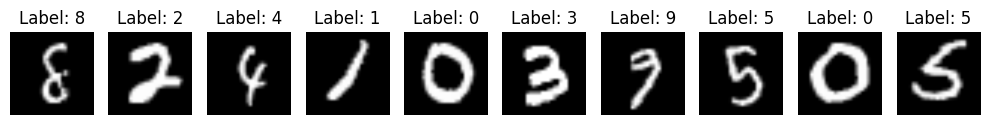

In [4]:
show_images_instance = ShowImages()

show_images_instance.show_images_loader(dataset_lodaer=train_data_loader, num_images_to_display=10)

In [9]:
model = models.vit_tiny_16_224(num_classes=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [8]:
train_loss_fn = nn.CrossEntropyLoss().cuda()
validate_loss_fn = nn.CrossEntropyLoss().cuda()

args = parser.parse_args(["--input-size", "3", "224", "224"])

EPOCHS = 30
BATCH_SIZE = 32
NUM_WORKERS = 2

optimizer = create_optimizer(args, model)

In [11]:
# Set up the learning rate scheduler (if needed)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = train_loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the learning rate (if using a scheduler)
        scheduler.step()

        # Track the total loss
        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_data_loader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {average_loss}")

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for inputs, labels in test_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the validation loss
            val_loss = validate_loss_fn(outputs, labels)

            # Track accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Save the trained model if needed
torch.save(model.state_dict(), 'trained_model.pth')

Epoch [1/30], Loss: 2.319947227994516
Validation Accuracy: 11.33%


KeyboardInterrupt: 